In [1]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import warnings
import os

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

2023-10-31 15:47:35.944411: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 15:47:36.613179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data

In [2]:
min_non_zero_pct = 0.5
window_size = 3
sequence_length = 10

df = load_and_merge()
df = remove_underpopulated_taxa(df, min_non_zero_pct)
df = standard_rolling_average(df, window_size)
df = feature_wise_scaling(df)

In [3]:
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,3304236,584137,193233,4334711,196664,583117,354850,subject_id,sampling_day,ind_time
E000823.4.0,0.000000,0.000160,0.288889,0.000000,0.000000,0.242718,0.010256,0.190476,0.000000,0.100671,...,0.029412,0.000000,0.040201,0.455696,0.059699,0.010154,0.064039,E000823,0.072046,0.072046
E000823.5.0,0.000000,0.000160,0.200000,0.000000,0.000000,0.199029,0.007692,0.119048,0.000000,0.120805,...,0.117647,0.000000,0.035804,0.398734,0.054162,0.010779,0.029557,E000823,0.100865,0.100865
E000823.5.7,0.000000,0.000180,0.200000,0.003724,0.000000,0.228155,0.007692,0.023810,0.000000,0.053691,...,0.117647,0.000000,0.034338,0.518987,0.060045,0.009685,0.019704,E000823,0.121037,0.121037
E000823.6.7,0.065636,0.000160,0.088889,0.016139,0.000000,0.121359,0.002564,0.023810,0.000000,0.080537,...,0.205882,0.000085,0.021566,0.386076,0.035127,0.006092,0.000000,E000823,0.149856,0.149856
E000823.8.5,0.065636,0.000220,0.177778,0.017381,0.000000,0.490291,0.020513,0.071429,0.000000,0.053691,...,0.176471,0.000085,0.050251,0.386076,0.061602,0.037334,0.000000,E000823,0.201729,0.201729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,0.060355,0.080890,0.288889,0.007449,0.044379,0.111650,0.025641,0.476190,0.479017,0.503356,...,0.470588,0.055292,0.091290,0.253165,0.127531,0.423113,0.068966,E014086,0.832853,0.832853
E014086.32.4,0.060355,0.120524,0.622222,0.010552,0.077663,0.194175,0.071795,0.404762,0.880928,0.711409,...,0.441176,0.071990,0.142169,0.341772,0.345042,0.622876,0.285714,E014086,0.890490,0.890490
E014086.33.5,0.051679,0.141802,1.000000,0.011173,0.161243,0.436893,0.074359,0.619048,0.849198,0.906040,...,0.264706,0.057024,0.213358,0.373418,0.537809,0.756436,0.507389,E014086,0.922190,0.922190
E014086.34.4,0.021124,0.127490,0.977778,0.004345,0.160503,0.572816,0.071795,0.571429,0.761174,0.899329,...,0.294118,0.037543,0.241625,0.316456,0.631597,0.749125,0.610837,E014086,0.948127,0.948127


## Features and targets

In [4]:
number_test_sequences = 3

train_feats, train_targets, test_feats, test_targets, test_subjects = feats_and_targets(df, seq_length=sequence_length, n_test_seq=number_test_sequences)

The test subjects are ['E013505' 'E010481' 'E011878']


In [5]:
print(len(train_feats), len(train_targets))

264 264


In [6]:
cols_pred = df.columns[~df.columns.isin(metadata_cols)]

In [7]:
train_targets = np.asarray(train_targets)
train_targets = pd.DataFrame(train_targets)
train_targets.columns = cols_pred

In [8]:
train_targets

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.139570,0.000340,0.288889,0.000000,0.052515,0.029126,0.117949,0.309524,0.107131,0.127517,...,0.432339,0.062500,0.000373,0.264706,0.015648,0.144472,0.101266,0.097422,0.226506,0.118227
1,0.091664,0.006506,0.466667,0.056487,0.055473,0.155340,0.043590,0.000000,0.001365,0.000000,...,0.012615,0.526786,0.136822,0.000000,0.007100,0.060092,0.569620,0.144316,0.024838,0.000000
2,0.245568,0.000040,0.155556,0.001241,0.076183,1.000000,0.010256,0.357143,0.061412,0.637584,...,0.347477,1.000000,0.000053,0.411765,0.000057,0.027848,0.202532,0.113341,0.002812,0.443350
3,0.001132,0.000180,0.022222,0.009311,0.028846,0.179612,0.002564,0.071429,0.136472,0.248322,...,0.087156,0.044643,0.000133,0.294118,0.008065,0.007328,0.031646,0.082540,0.000312,0.039409
4,0.000000,0.000120,0.466667,0.001241,0.002959,0.228155,0.002564,0.380952,0.079836,0.409396,...,0.530963,0.196429,0.000000,0.117647,0.004260,0.047320,0.151899,0.228240,0.531086,0.054187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0.000000,0.000020,0.266667,0.001862,0.560651,0.364078,0.002564,0.166667,0.000000,0.375839,...,0.636468,0.133929,0.292874,0.235294,0.000028,0.031407,0.278481,0.040318,0.000812,0.192118
260,0.066013,0.000881,0.155556,0.000000,0.044379,0.199029,0.076923,0.214286,0.025930,0.255034,...,0.034404,0.026786,0.001040,0.176471,0.000795,0.111809,0.012658,0.175463,0.146307,0.256158
261,0.000000,0.000240,0.000000,0.003724,0.005917,0.000000,0.000000,0.095238,0.000341,0.046980,...,0.128440,0.000000,0.037419,0.147059,0.059410,0.000209,0.000000,0.000865,0.000156,0.014778
262,0.022256,0.000661,0.177778,0.012415,0.034024,0.213592,0.166667,0.166667,0.000341,0.046980,...,0.338303,0.133929,0.076999,0.058824,0.001193,0.520310,0.107595,0.214224,0.180549,0.349754


## The model

In [9]:
def fetch_model(seq_length):

    reg = 1e-8
    
    n_ins = len(train_feats[0][0])
    
    model = Sequential()
    model.add(keras.Input(shape=(seq_length, n_ins)))
    model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
    model.add(keras.layers.Dense(512, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(128, activation="relu", kernel_regularizer=l1_l2(reg)))
    model.add(keras.layers.Dense(1, activation="relu"))
    
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    
    return model

In [10]:
def compile_model(model, loss):
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    return model

In [11]:
#model = fetch_model()
#
#model.summary()
#
#model.save("/home/nate/temp/test_model_save.model")

## Individual model testbench

In [12]:
y_true = tf.constant([0])
y_pred = tf.constant([1])

loss = mae_ignore_zeros(false_positives_penalty_factor=0.3)
loss.call(y_true, y_pred)

2023-10-31 15:47:45.917861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:47:45.935694: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 15:47:45.935942: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

<tf.Tensor: shape=(), dtype=float64, numpy=nan>

In [13]:
target_taxa = 364179

plot=False

if plot is True:
    plot_a_taxa_sequence(train_targets[target_taxa], title=f"Train sequence for taxa_idx {target_taxa}", color="blue")

In [14]:
n_epochs = 15

#loss = mae_ignore_zeros(false_positives_penalty_factor=0.3)
loss = "mae"

model = fetch_model(seq_length=sequence_length)
model = compile_model(model, loss)

model.fit(x=train_feats, y=train_targets[target_taxa], validation_split=0.05, epochs=n_epochs, verbose=1)

Epoch 1/15


2023-10-31 15:47:48.867201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-31 15:47:48.919734: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6a48d4f900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-31 15:47:48.919763: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-10-31 15:47:48.924548: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-31 15:47:48.937789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-31 15:47:49.051809: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

8/8 [==============================] - 2s 45ms/step - loss: 7.6791 - mae: 0.0212 - mape: 92.8000 - val_loss: 6.2117 - val_mae: 0.0681 - val_mape: 78.5714
Epoch 2/15
8/8 [==============================] - 0s 17ms/step - loss: 5.2382 - mae: 0.0212 - mape: 95.7618 - val_loss: 4.1700 - val_mae: 0.0681 - val_mape: 78.5714
Epoch 3/15
8/8 [==============================] - 0s 16ms/step - loss: 3.4631 - mae: 0.0212 - mape: 92.8000 - val_loss: 2.7276 - val_mae: 0.0681 - val_mape: 78.5714
Epoch 4/15
8/8 [==============================] - 0s 16ms/step - loss: 2.2306 - mae: 0.0212 - mape: 92.8000 - val_loss: 1.7510 - val_mae: 0.0681 - val_mape: 78.5714
Epoch 5/15
8/8 [==============================] - 0s 18ms/step - loss: 1.4085 - mae: 0.0212 - mape: 92.8000 - val_loss: 1.1135 - val_mae: 0.0681 - val_mape: 78.5714
Epoch 6/15
8/8 [==============================] - 0s 17ms/step - loss: 0.8786 - mae: 0.0212 - mape: 92.8000 - val_loss: 0.7100 - val_mae: 0.0681 - val_mape: 78.5714
Epoch 7/15
8/8 [=====

In [15]:
test_subjects

array(['E013505', 'E010481', 'E011878'], dtype=object)

In [16]:
target_subject_idx = 0
target_subject = test_subjects[target_subject_idx]

test_subject_feats = np.asarray(test_feats[target_subject])

test_subject_targets = pd.concat(test_targets[target_subject]).T
test_subject_targets.columns = df.columns[:-1]

1/1 [==============================] - 0s 123ms/step


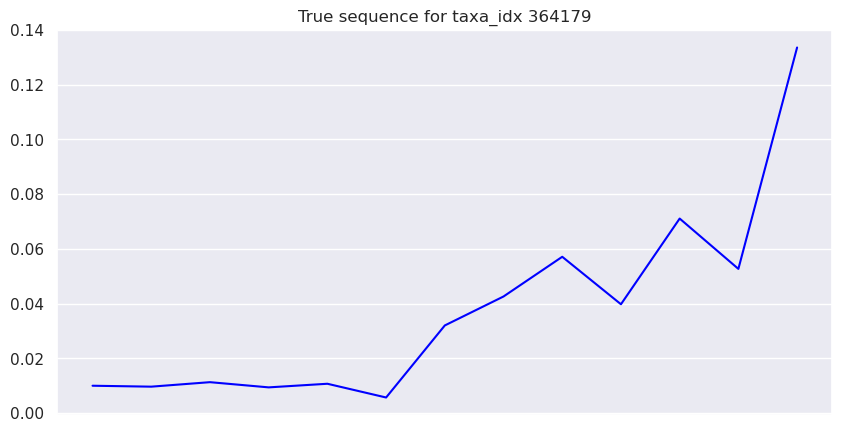

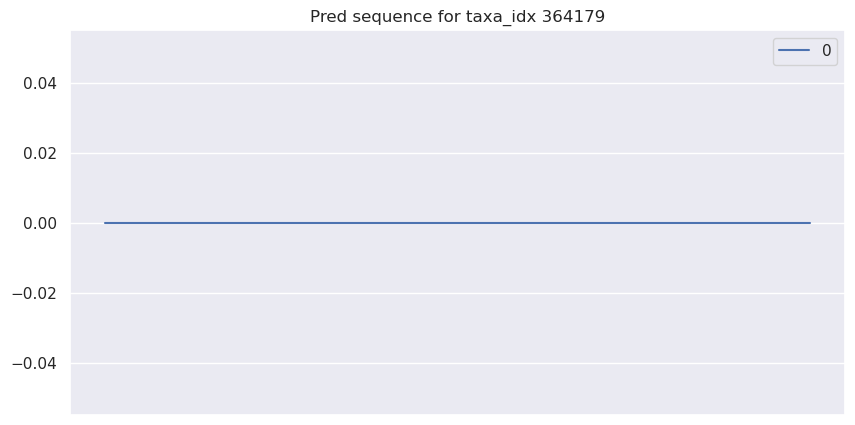

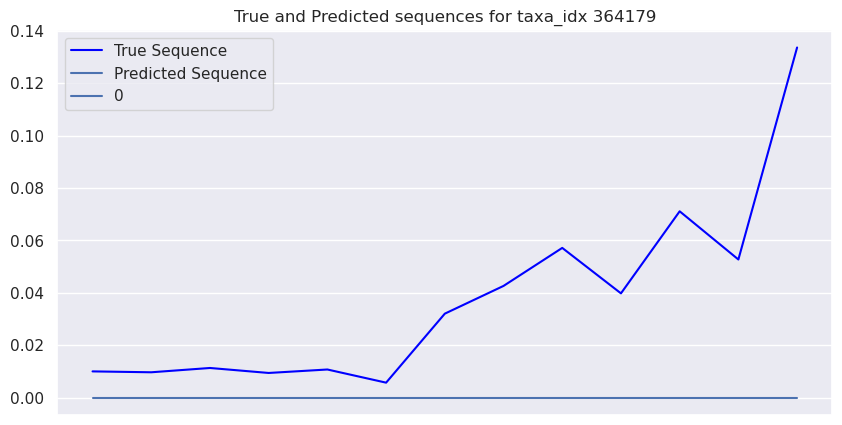

In [17]:
y_pred = model.predict(test_subject_feats)

true_sequence = test_subject_targets[target_taxa].reset_index(drop=True)
pred_sequence = y_pred

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

## The Ensemble

In [18]:
class ensemble():
        
    def __init__(self, ensemble_name, loss, seq_length, overwrite_on_train=False):
        
        self.models_out_dir = f"{root_dir}/models/{ensemble_name}"
        self.overwrite_on_train = overwrite_on_train
        self.loss = loss
        self.seq_length = seq_length

        
    def train(self, X_sequences_train, y_targets_train, n_epochs):
        
        # hardcoded stuff
        ignore_cols = ["subject_id", "sampling_day", "ind_time"]
        
        if not os.path.exists(self.models_out_dir):
            os.mkdir(self.models_out_dir)
        else:
            if self.overwrite_on_train is False:
                raise Exception("This model dir already exists")
            else:
                print("Overwriting an existing model dir")
                shutil.rmtree(self.models_out_dir)
                os.mkdir(self.models_out_dir)
                
        for taxa_idx in tqdm(y_targets_train.columns, desc="Training models"):
            
            if taxa_idx not in ignore_cols:
            
                model = fetch_model(seq_length=self.seq_length)
                model = compile_model(model, loss)
                y_targets = y_targets_train[taxa_idx]
                model.fit(x=X_sequences_train, y=y_targets, validation_split=0.05, epochs=n_epochs, verbose=0)
                
                model.save(f"{self.models_out_dir}/{taxa_idx}.model")
            
                del model
            
    
    def load(self):
        
        self.model_dic = {}

        for model_dir in tqdm(os.listdir(self.models_out_dir), desc="Loading the models"):
            taxa_idx = int(model_dir.replace(".model", ""))
            
            if isinstance(loss, mae_ignore_zeros):
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model", compile=False)
                model = compile_model(model, loss)
            else:
                model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model")
                 
            self.model_dic[taxa_idx] = model
    
         
    def predict(self, X_sequences):
        
        self.load()
        
        n_sequences = len(X_sequences)
        
        pred_list = []
        for taxa_idx in tqdm(self.model_dic.keys(), desc="Predicting values"):
            model = self.model_dic[taxa_idx]
            pred_list.append(model.predict(X_sequences, verbose=0).reshape(n_sequences,))
            del(model)
            
        pred_df = pd.DataFrame(pred_list).T
            
        return pred_df

In [19]:
# Tensorflow does not play nice with my Linux machine, thus I am filtering out its warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#loss = mae_ignore_zeros(false_positives_penalty_factor=0.1)
loss = "mae"

model_ensemble = ensemble(ensemble_name="test_ensemble", loss=loss, overwrite_on_train=True, seq_length=sequence_length)

In [20]:
train_targets

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.139570,0.000340,0.288889,0.000000,0.052515,0.029126,0.117949,0.309524,0.107131,0.127517,...,0.432339,0.062500,0.000373,0.264706,0.015648,0.144472,0.101266,0.097422,0.226506,0.118227
1,0.091664,0.006506,0.466667,0.056487,0.055473,0.155340,0.043590,0.000000,0.001365,0.000000,...,0.012615,0.526786,0.136822,0.000000,0.007100,0.060092,0.569620,0.144316,0.024838,0.000000
2,0.245568,0.000040,0.155556,0.001241,0.076183,1.000000,0.010256,0.357143,0.061412,0.637584,...,0.347477,1.000000,0.000053,0.411765,0.000057,0.027848,0.202532,0.113341,0.002812,0.443350
3,0.001132,0.000180,0.022222,0.009311,0.028846,0.179612,0.002564,0.071429,0.136472,0.248322,...,0.087156,0.044643,0.000133,0.294118,0.008065,0.007328,0.031646,0.082540,0.000312,0.039409
4,0.000000,0.000120,0.466667,0.001241,0.002959,0.228155,0.002564,0.380952,0.079836,0.409396,...,0.530963,0.196429,0.000000,0.117647,0.004260,0.047320,0.151899,0.228240,0.531086,0.054187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0.000000,0.000020,0.266667,0.001862,0.560651,0.364078,0.002564,0.166667,0.000000,0.375839,...,0.636468,0.133929,0.292874,0.235294,0.000028,0.031407,0.278481,0.040318,0.000812,0.192118
260,0.066013,0.000881,0.155556,0.000000,0.044379,0.199029,0.076923,0.214286,0.025930,0.255034,...,0.034404,0.026786,0.001040,0.176471,0.000795,0.111809,0.012658,0.175463,0.146307,0.256158
261,0.000000,0.000240,0.000000,0.003724,0.005917,0.000000,0.000000,0.095238,0.000341,0.046980,...,0.128440,0.000000,0.037419,0.147059,0.059410,0.000209,0.000000,0.000865,0.000156,0.014778
262,0.022256,0.000661,0.177778,0.012415,0.034024,0.213592,0.166667,0.166667,0.000341,0.046980,...,0.338303,0.133929,0.076999,0.058824,0.001193,0.520310,0.107595,0.214224,0.180549,0.349754


In [21]:
#model_ensemble.train(X_sequences_train=train_feats, y_targets_train=train_targets, n_epochs=15)

## Validation

In [22]:
test_subjects

array(['E013505', 'E010481', 'E011878'], dtype=object)

In [23]:
target_subject_idx = 0
target_subject = test_subjects[target_subject_idx]

target_subject_y_test_df = pd.concat(test_targets[target_subject], axis=1).T
target_subject_y_test_df.columns = df.columns[:-1]

target_subject_y_test_df = target_subject_y_test_df.reset_index(drop=True).drop(columns=["subject_id", "sampling_day"])
target_subject_y_test_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.000000,0.009969,0.400000,0.009932,0.016272,0.067961,0.066667,0.309524,0.229614,0.087248,...,0.425459,0.071429,0.042140,0.264706,0.025900,0.105318,0.107595,0.154179,0.229880,0.054187
1,0.000000,0.009628,0.355556,0.009932,0.015533,0.067961,0.064103,0.309524,0.234050,0.107383,...,0.424312,0.071429,0.042033,0.264706,0.025246,0.104481,0.094937,0.155390,0.237253,0.211823
2,0.000754,0.011270,0.177778,0.002483,0.005917,0.038835,0.058974,0.476190,0.042648,0.140940,...,0.372706,0.026786,0.018483,0.264706,0.057223,0.080402,0.101266,0.075446,0.165646,0.216749
3,0.000754,0.009368,0.044444,0.004966,0.006657,0.000000,0.035897,0.261905,0.013988,0.100671,...,0.130734,0.000000,0.000133,0.000000,0.064862,0.039363,0.037975,0.030801,0.021120,0.374384
4,0.000754,0.010689,0.066667,0.015518,0.006657,0.000000,0.074359,0.333333,0.068918,0.241611,...,0.481651,0.008929,0.003147,0.147059,0.156505,0.087312,0.037975,0.068178,0.047332,0.261084
5,0.000000,0.005665,0.088889,0.016760,0.003698,0.000000,0.048718,0.190476,0.066871,0.268456,...,0.426606,0.017857,0.003014,0.147059,0.105330,0.073492,0.012658,0.056065,0.042864,0.270936
6,0.000000,0.032008,0.088889,0.012415,0.003698,0.004854,0.084615,0.095238,0.083930,0.234899,...,0.455275,0.026786,0.003067,0.147059,0.118905,0.095687,0.018987,0.065755,0.061922,0.068966
7,0.000000,0.042597,0.088889,0.032899,0.009615,0.048544,0.161538,0.071429,0.037189,0.107383,...,0.147936,0.026786,0.000053,0.029412,0.042144,0.122487,0.025316,0.103132,0.069108,0.054187
8,0.000000,0.057109,0.133333,0.031657,0.011095,0.063107,0.292308,0.071429,0.219379,0.208054,...,0.344037,0.017857,0.000187,0.176471,0.077045,0.272404,0.031646,0.281537,0.157179,0.064039
9,0.000000,0.039754,0.177778,0.032278,0.020710,0.106796,0.443590,0.071429,0.373251,0.221477,...,0.350917,0.071429,0.000187,0.294118,0.082498,0.443467,0.044304,0.448347,0.212009,0.064039


In [24]:
target_subject_feats = np.asarray(test_feats[target_subject])
target_subject_y_pred_df = model_ensemble.predict(target_subject_feats)

Loading the models:  24%|██▍       | 48/202 [01:05<03:23,  1.32s/it]2023-10-31 15:49:22.396832: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB (rounded to 16777216)requested by op Identity
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-10-31 15:49:22.396916: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-10-31 15:49:22.396924: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 692, Chunks in use: 692. 173.0KiB allocated for chunks. 173.0KiB in use in bin. 2.8KiB client-requested in use in bin.
2023-10-31 15:49:22.396930: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 108, Chunks in use: 108. 57.2KiB allocated for chunks. 57.2KiB in use in bin. 54.0KiB client-reque

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Identity: Dst tensor is not initialized. [Op:Identity] name: 

In [ ]:
target_subject_y_pred_df = target_subject_y_pred_df.reset_index(drop=True)
target_subject_y_pred_df.columns = target_subject_y_test_df.columns
target_subject_y_pred_df

In [ ]:
non_predicted_cols = [col for col in target_subject_y_pred_df.columns if all(target_subject_y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(target_subject_y_pred_df.columns)) * 100}% of all taxa")

In [ ]:
target_taxa = 189384

true_sequence = target_subject_y_test_df[target_taxa].reset_index(drop=True)
pred_sequence = target_subject_y_pred_df[target_taxa]

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

In [ ]:
def fetch_subject_y_true_and_y_pred(test_subjects, model, df, target_subject_idx, test_feats, test_targets):
    
    cols_true = df.columns[df.columns != "subject_id"]
    cols_pred = df.columns[~df.columns.isin(metadata_cols)]
    
    target_subject = test_subjects[target_subject_idx]
    
    test_subject_feats = np.asarray(test_feats[target_subject])
    test_subject_targets_df = pd.concat(test_targets[target_subject], axis=1).T
    
    test_subject_targets_df.columns = cols_true
    test_subject_y_pred = model.predict(test_subject_feats)
    
    test_subject_y_pred_df = pd.DataFrame(test_subject_y_pred)
    test_subject_y_pred_df.columns = cols_pred
    test_subject_y_pred_df.index = test_subject_targets_df.index

    return test_subject_targets_df, test_subject_y_pred_df

In [ ]:
subjects_error_dfs = []
for target_subject_idx in range(len(test_subjects)):
    
    test_subject_targets_df, test_subject_y_pred_df = fetch_subject_y_true_and_y_pred(test_subjects, model_ensemble, df, target_subject_idx, test_feats, test_targets, experiment_id=2)

    errors_df = calculate_percentage_errors(test_subject_y_pred_df, test_subject_targets_df)
    subjects_error_dfs.append(errors_df)
    
errors_df = pd.concat(subjects_error_dfs)

In [ ]:
percentile_graph(errors_df, "accross all taxa", y_top_lim=1)

In [ ]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

In [ ]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa LSTM sequence on Float", y_top_lim=1)